### Main algorithm to generating Graphs

In [2]:
import math
import networkx as nx
import numpy as np


def create_graph(sigma, _lambda=5, _N=1000):
  for _ in range(100):
    # Generate weibull distribution samples
    seq = np.random.weibull(-1*math.log(sigma), _N) * _lambda
    # Round all samples
    seq = np.round(seq).astype(int)
    # Make even the summation of all degree distribution
    seq = [_N-2 if val >= _N else val for val in seq]
    # Prevent from degree==0 to generate connected graphs
    seq = [1 if val == 0 else val for val in seq]
    # Make all samples even
    seq = [d + 1 if d % 2 != 0 else d for d in seq]
    # Try Configuration Model to generate graph
    g = nx.configuration_model(seq)
    g = nx.Graph(g)
    # Remove self loops on eatch edge
    g.remove_edges_from(nx.selfloop_edges(g))
    if nx.is_connected(g):
      graph = nx.to_numpy_array(g)
      # Remove multy edges between 2 node
      graph[graph!=0] = 1.0
      graph_nx = nx.from_numpy_array(graph)
      return graph_nx, seq
  raise ValueError("Could not generate a connected graph after 200 attempts.")

### Plot the Topological Features

In [3]:
def topological_features(graph):
  return {
    'N': np.round(graph.number_of_nodes(), 2),
    'M': np.round(graph.number_of_edges(), 2),
    '<K>': np.round(graph.number_of_edges()*2/graph.number_of_nodes(), 2),
    '<L>': np.round(nx.average_shortest_path_length(graph), 2),
    'C': np.round(nx.average_clustering(graph), 2),
  }


from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import json
import pandas as pd

def plot_topological_features(indices_performance):
  df = pd.DataFrame(indices_performance).T
  for _, value in indices_performance.items():
    keys = value.keys()
    break
  df.columns = list(keys)

  fig, ax = plt.subplots(figsize=(10, 6))
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  ax.set_frame_on(False)

  table = ax.table(cellText=df.round(4).values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')
  with PdfPages('topological_features.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

  plt.savefig(f'topological_features.jpg')
  plt.show()

### Check the Topological Features for a single sigma=0.5

100%|██████████| 40/40 [00:17<00:00,  2.30it/s]


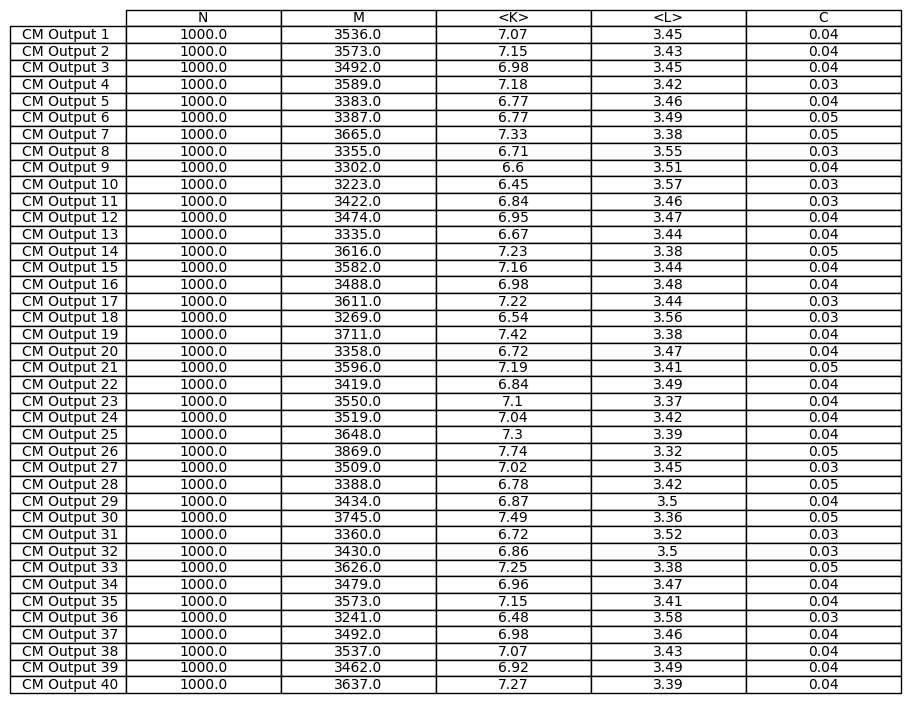

In [4]:
from tqdm import tqdm


cm_alpha_val = []
cm_graph = []

indices_performance = {}

output_model = []
for i in tqdm(range(40)):
    g, seq = create_graph(0.50, _N=1000)
    cm_graph.append(g)
    indices_performance[f'CM Output {i+1}'] = topological_features(g)

plot_topological_features(indices_performance)

### Comparison of the logarithms of the largest eigenvalue calculated by the theory of and the empirically calculated value as a function of heterogeneity.

In [10]:
from scipy.sparse.linalg import eigs


def create_seq(sigma, _lambda=5, _N=5000):
    seq = np.random.weibull(-1*math.log(sigma), _N) * _lambda
    seq = np.round(seq).astype(int)
    return seq


data = []
theory = []
homogeneity = []

_min = 0.001
_max = 0.8
steps = 200


for sigma in tqdm(np.linspace(_min, _max, steps)):
    mean_alpha = 0
    mean_largest_eigenvalue = 0
    mean_theory_largest_eigenvalue = 0
    EPOCH=10
    for _ in range(EPOCH):

        seq = create_seq(sigma=sigma, _N=5000)
        degrees = seq
        mean_degree = np.mean(degrees)
        var_degree = np.var(degrees)
        largest_eigenvalue = var_degree / mean_degree if mean_degree != 0 else 0
        mean_theory_largest_eigenvalue = mean_theory_largest_eigenvalue + largest_eigenvalue

        g, seq = create_graph(sigma, _N=5000)

        # Calculating actual largest eigenvalue based on adjacency matrix of created graph
        A_sparse = nx.adjacency_matrix(g).astype(float)
        largest_eigenvalue = eigs(A_sparse, k=1, which='LM', return_eigenvectors=False)
        largest_eigenvalue = np.abs(largest_eigenvalue[0])
        mean_largest_eigenvalue += largest_eigenvalue

    mean_largest_eigenvalue/=EPOCH
    mean_theory_largest_eigenvalue/=EPOCH
    
    data.append(mean_largest_eigenvalue)
    theory.append(mean_theory_largest_eigenvalue)

100%|██████████| 200/200 [16:19<00:00,  4.90s/it]


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_12776/2378510072.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Log of Largest Eigenvalues vs. $\sigma$")
/tmp/ipykernel_12776/2378510072.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma$")
/tmp/ipykernel_12776/2378510072.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("log($\lambda_{largest}$)")


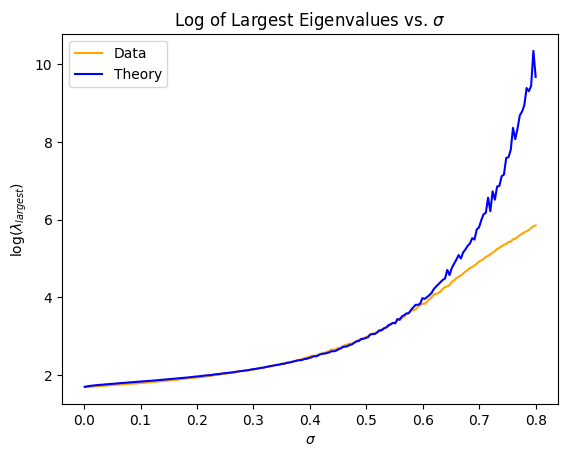

In [11]:
x = np.linspace(_min, _max, steps)
plt.plot(x, [math.log(val) for val in data], color='orange', label="Data")
plt.plot(x, [math.log(val + (min(data) - min(theory))) for val in theory], color='blue', label='Theory')
plt.title("Log of Largest Eigenvalues vs. $\sigma$")
plt.xlabel("$\sigma$")
plt.ylabel("log($\lambda_{largest}$)")
plt.legend()
plt.show()